In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import poisson, binom, geom

In [0]:
### Defining the counties name ###
counties_name = ['Bronx County','Kings County','Richmond County','Queens County','New York County']

In [0]:
### Loading the 3 datasets for Covid19 ###
counties_population = pd.read_csv('covid_county_population_usafacts.csv')
counties_confirmed = pd.read_csv('covid_confirmed_usafacts.csv')
counties_death = pd.read_csv('covid_deaths_usafacts.csv')

In [0]:
### Getting the subset with the counties we are working on ###
counties_population = counties_population[counties_population['County Name'].isin(counties_name) & (counties_population['State'] == 'NY')]
counties_confirmed = counties_confirmed[counties_confirmed['County Name'].isin(counties_name) & (counties_confirmed['State'] == 'NY')]
counties_death = counties_death[counties_death['County Name'].isin(counties_name) & (counties_death['State'] == 'NY')]

In [0]:
counties_death.head()

,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,02-01-2020,02-02-2020,02-03-2020,02-04-2020,02-05-2020,02-06-2020,02-07-2020,02-08-2020,02-09-2020,02-10-2020,02-11-2020,02-12-2020,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,04-01-2020,04-02-2020,04-03-2020,04-04-2020,04-05-2020,04-06-2020,04-07-2020,04-08-2020,04-09-2020,04-10-2020,04-11-2020,04-12-2020,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20
1865,36005,Bronx County,NY,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,14,28,44,60,79,101,152,188,215,262,360,421,480,576,627,709,902,1001,1046,1241,1308,1400,1434,2006,2153,2227,2288,2302,2586,2673,2772,2879,3000,3075,3171,3216,3285,3357,3400,3435
1886,36047,Kings County,NY,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,14,27,45,64,81,102,167,185,215,261,328,385,485,610,896,1022,1153,1313,1473,1640,1843,2028,2132,3154,3337,3476,3575,3612,4027,4178,4348,4512,4648,4793,4978,5075,5164,5281,5332,5390
1893,36061,New York County,NY,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,10,19,35,43,55,65,93,103,119,129,165,178,215,264,390,436,513,604,674,731,799,849,849,1298,1319,1370,1401,1413,1569,1630,1682,1767,1812,1834,1952,1973,1999,2035,2060,2100
1903,36081,Queens County,NY,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,21,40,60,92,124,149,216,253,305,376,447,499,590,685,813,948,1129,1344,1400,1759,1848,2116,2116,2948,3208,3358,3426,3466,3878,4026,4204,4345,4463,4571,4723,4800,4870,4983,5070,5150
1905,36085,Richmond County,NY,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,11,4,21,26,33,43,46,58,67,73,78,96,118,150,172,196,229,246,289,305,330,343,417,445,473,482,488,537,555,572,592,614,632,658,661,674,687,694,705


## Question 4c

In [0]:
#  The Null hypothesis is that the scoring distribution remains the same

In [0]:
def plot(a, label, min_x = 0, max_x = 10):
    n = len(a)
    Srt = sorted(a)
    X = [min_x]
    Y = [0]
    cdf = [0.0]
    for i in range(0, n):
        X = X + [Srt[i], Srt[i]]
        Y = Y + [Y[len(Y)-1], Y[len(Y)-1]+(1/n)]
        cdf = cdf + [Y[len(Y)-1]]
    X = X + [max_x]
    Y = Y + [1.0]

    plt.plot(X,Y, label=label)
    plt.xlabel('x')
    plt.ylabel('Pr[X<=x]')
    plt.legend(loc='best')
    return cdf
    
def find_cdf_at(X, CDF, change_point):
    # First find the first element larger than the change_point
    index = -1
    for i, x in enumerate(X):
        if x >= change_point:
            index = i
            break
    # Return the CDF value at that point
    return CDF[index]

def k_s_test(X, Y, week, threshold = 0.05):
    X = sorted(X)
    Y = sorted(Y)
    
    x_min = min(X[0], Y[0]) - 5000
    x_max = max(X[len(X) - 1], Y[len(Y) - 1]) + 5000
    fig= plt.figure(figsize=(12,9))
    plt.grid(True)
    
    x_cdf = plot(X, 'week ' + str(week), x_min, x_max)
    y_cdf = plot(Y, 'week ' + str(week+1), x_min, x_max)      
    
    Fx = [find_cdf_at(X, x_cdf, change_point) for change_point in Y]
    Fy_minus = y_cdf[0:-1]
    Fy_plus = y_cdf[1:]

    max_val = 0
    max_index = 0
    left = True
    for i in range(0, len(Fx)):
        if abs(Fx[i] - Fy_minus[i]) > max_val:
            max_val = abs(Fx[i] - Fy_minus[i])
            max_index = i
            left = True
        if abs(Fx[i] - Fy_plus[i]) > max_val:
            max_val = abs(Fx[i] - Fy_plus[i])
            max_index = i
            left = False

    delta = -0.01
    ymin = 0
    ymax = 0
    if left == False:
        delta = delta * -1
        # Also need to find the limits for the vertical line
        ymin = min(Fy_plus[max_index], Fx[max_index])
    else:
        ymin = min(Fy_minus[max_index], Fx[max_index])
    
    print("Max value is {0} at X={1}".format(max_val, Y[max_index]))
    if max_val > threshold:
        print("D > C, We fail to reject Null Hypothesis")

    # plt.axvline(x=Y[max_index], ymax=ymin+max_val, ymin = ymin)
    plt.plot([Y[max_index],Y[max_index]],[ymin,ymin+max_val])
    annotation_str = "Max Diff=" , max_val
    plt.annotate(annotation_str, xy = [Y[max_index], ymin+max_val/2])

    return 


In [0]:
def k_s_test_1_sample(Fx, Fy, threshold = 0.05):
    Fx_minus = x_cdf[0:-1]
    Fx_plus = x_cdf[1:]

    max_val = 0
    max_index = 0
    left = True
    for i in range(0, len(X)):
        if abs(Fy[i] - Fx_minus[i]) > max_val:
            max_val = abs(Fy[i] - Fx_minus[i])
            max_index = i
            left = True
        if abs(Fy[i] - Fx_plus[i]) > max_val:
            max_val = abs(Fy[i] - Fx_plus[i])
            max_index = i
            left = False

    if max_val > threshold:
        print("D > C, We reject Null Hypothesis")

    return 

In [0]:
# Get last two weeks data
two_weeks_confirmed = counties_confirmed[counties_confirmed.columns[-14:]].sum(axis=0).to_numpy()
two_weeks_death = counties_confirmed[counties_confirmed.columns[-14:]].sum(axis=0).to_numpy()

### 2 Sample KS Test

Max value is 0.9999999999999998 at X=155113
D > C, We fail to reject Null Hypothesis


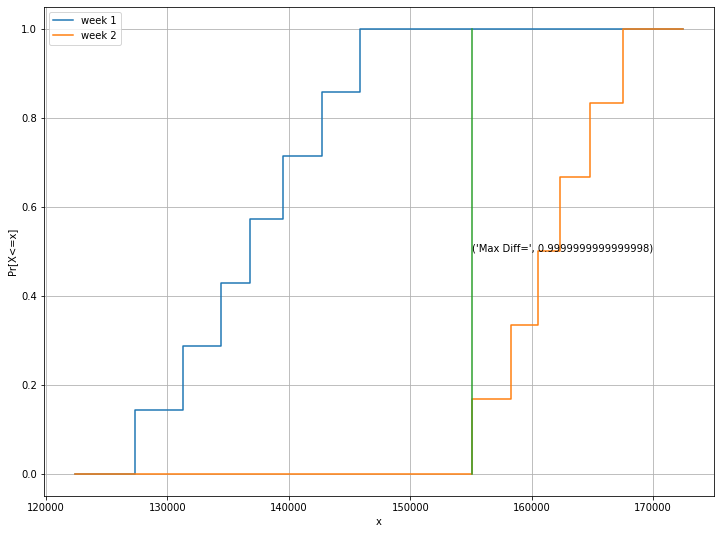

In [0]:
k_s_test(two_weeks_confirmed[0:7], two_weeks_confirmed[8:], 1)

### 1 Sample KS Test with Poisson, Geometric, Binomial distribution

In [0]:
X = sorted(two_weeks_confirmed[7:])
Fx = [0]
for i in range(0, len(X)):
    Fx = Fx + [Fx[len(Fx)-1] + 1/len(X)]

# First lets sample mean for the second last week
X_bar = np.mean(two_weeks_confirmed[0:7])

#### Poisson Distribution

In [0]:
# First get all the cdf values for Poisson distribution
Fy = [poisson.cdf(change_point, X_bar) for change_point in X]

k_s_test_1_sample(Fx, Fy)

D > C, We reject Null Hypothesis


#### Binomial distribution

n_mme = (X_bar)^2/(X_bar - S)

p_mme = 1 - S/X_bar

X_bar is the sample mean, S is the sample variance

In [0]:
X_bar = sample_mean
S = np.var(two_weeks_confirmed[0:7])

n_binom_mme = X_bar*X_bar/(X_bar - S)
p_binom_mme = 1 - S/X_bar

Fy = [binom.cdf(change_point, n_binom_mme, p_binom_mme) for change_point in X]
k_s_test_1_sample(Fx, Fy)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
D > C, We reject Null Hypothesis


#### Geometric Distribution

p_mme = 1/X_bar

In [0]:
p_geom_mme = 1/X_bar
Fy = [geom.cdf(change_point, p_geom_mme) for change_point in X]
k_s_test_1_sample(Fx, Fy)

D > C, We reject Null Hypothesis
